In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Load dataset
data = pd.read_csv("students_dataset.csv")

In [3]:
# Display basic info
print(data.info())
print(data.describe())
print(data.head())

# Check for missing values
print("Missing values per column:\n", data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   student_id                 3000 non-null   object
 1   stress_level               3000 non-null   object
 2   cognitive_performance      3000 non-null   object
 3   number sequences marks     3000 non-null   int64 
 4   perimeter marks            3000 non-null   int64 
 5   ratio marks                3000 non-null   int64 
 6   fractions/decimals marks   3000 non-null   int64 
 7   indices marks              3000 non-null   int64 
 8   algebra marks              3000 non-null   int64 
 9   angles marks               3000 non-null   int64 
 10  volume and capacity marks  3000 non-null   int64 
 11  area marks                 3000 non-null   int64 
 12  probability marks          3000 non-null   int64 
 13  recommended_lesson         3000 non-null   object
dtypes: int64

C:\Users\MSI\AppData\Local\Temp\ipykernel_24004\2680186794.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="recommended_lesson", data=data, order=data["recommended_lesson"].value_counts().index, palette="viridis")


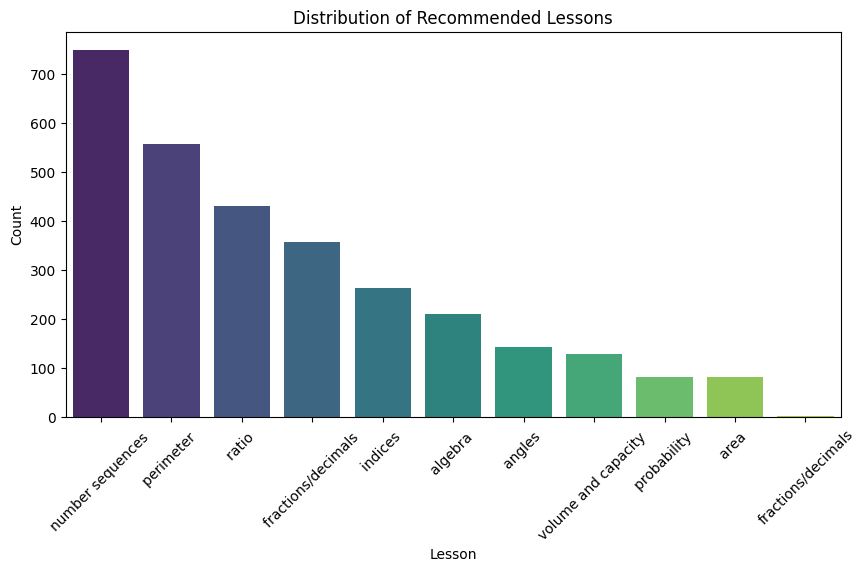

In [4]:
plt.figure(figsize=(10, 5))
sns.countplot(x="recommended_lesson", data=data, order=data["recommended_lesson"].value_counts().index, palette="viridis")
plt.xticks(rotation=45)
plt.title("Distribution of Recommended Lessons")
plt.xlabel("Lesson")
plt.ylabel("Count")
plt.show()

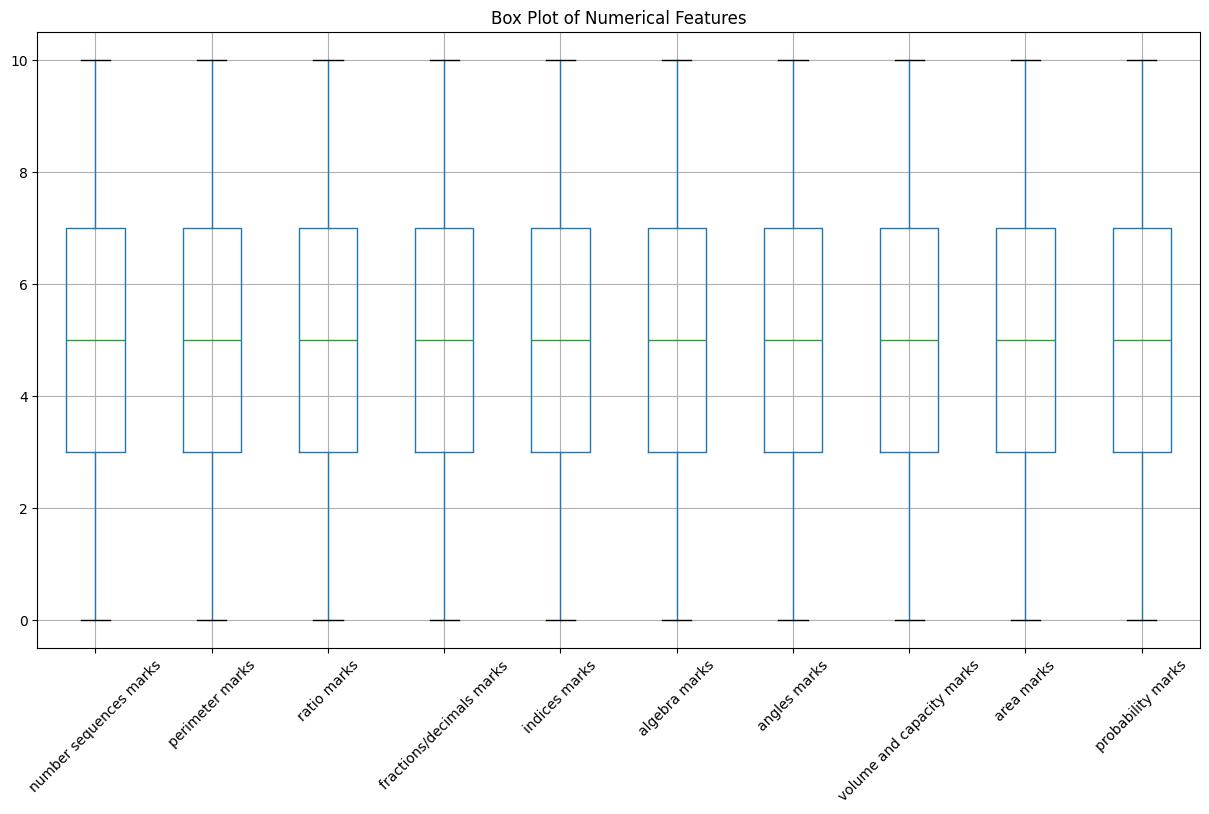

In [5]:
numerical_cols = data.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(15, 8))
data[numerical_cols].boxplot(rot=45)
plt.title("Box Plot of Numerical Features")
plt.show()


C:\Users\MSI\AppData\Local\Temp\ipykernel_24004\2267223234.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="stress_level", data=data, palette="Set2")


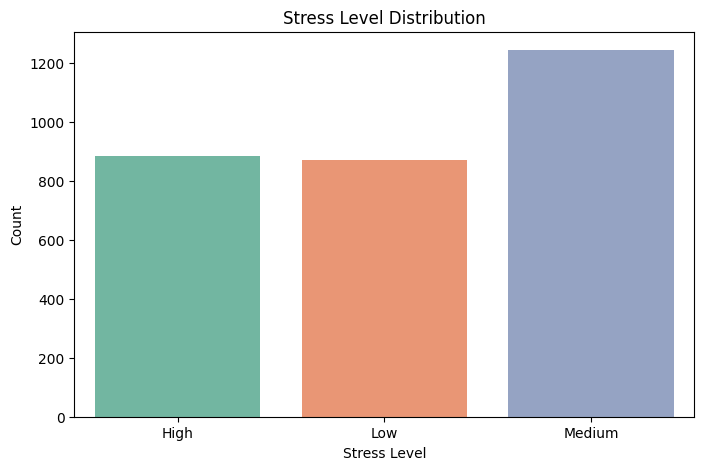

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(x="stress_level", data=data, palette="Set2")
plt.title("Stress Level Distribution")
plt.xlabel("Stress Level")
plt.ylabel("Count")
plt.show()


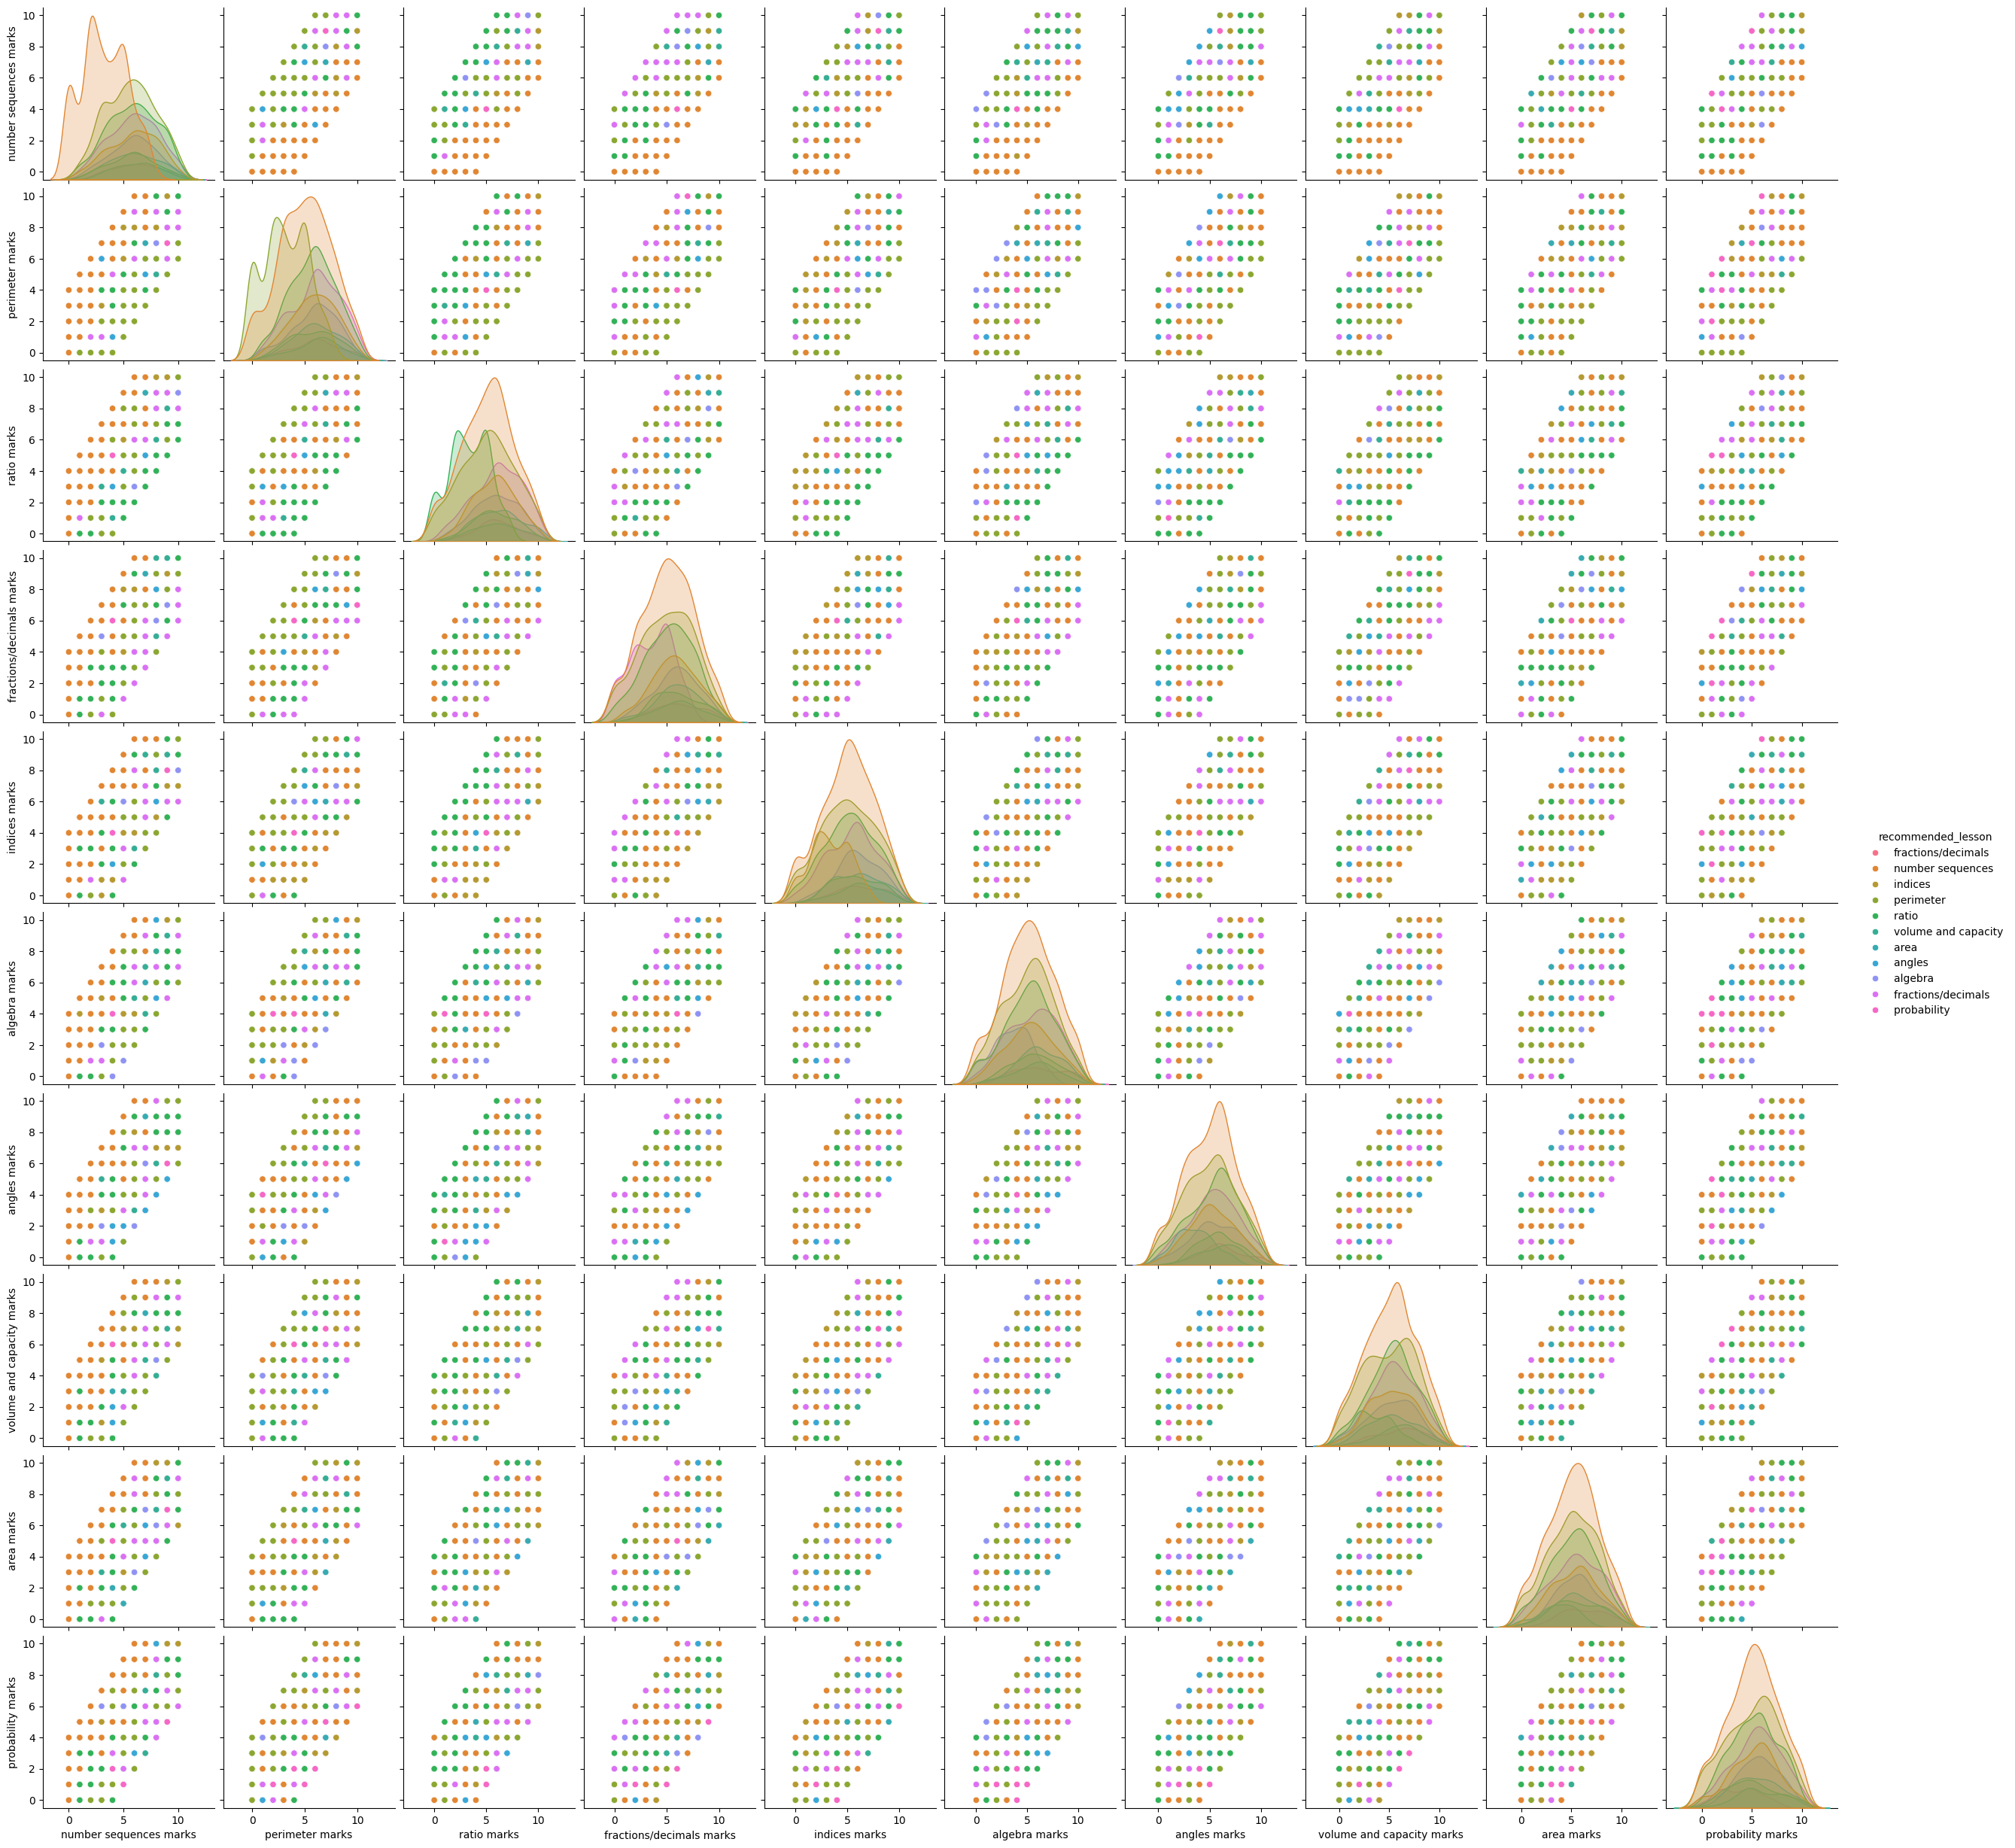

In [7]:
sns.pairplot(data, hue="recommended_lesson", diag_kind="kde", palette="husl")
plt.show()

C:\Users\MSI\AppData\Local\Temp\ipykernel_24004\2362476198.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="recommended_lesson", y="probability marks", data=data, palette="pastel")


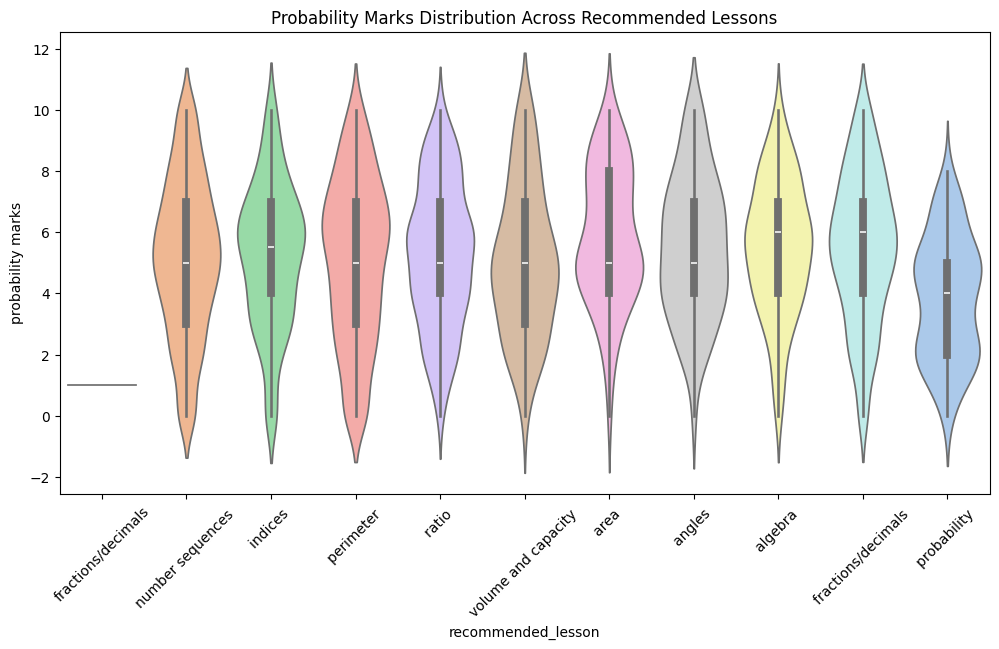

In [8]:
plt.figure(figsize=(12, 6))
sns.violinplot(x="recommended_lesson", y="probability marks", data=data, palette="pastel")
plt.xticks(rotation=45)
plt.title("Probability Marks Distribution Across Recommended Lessons")
plt.show()

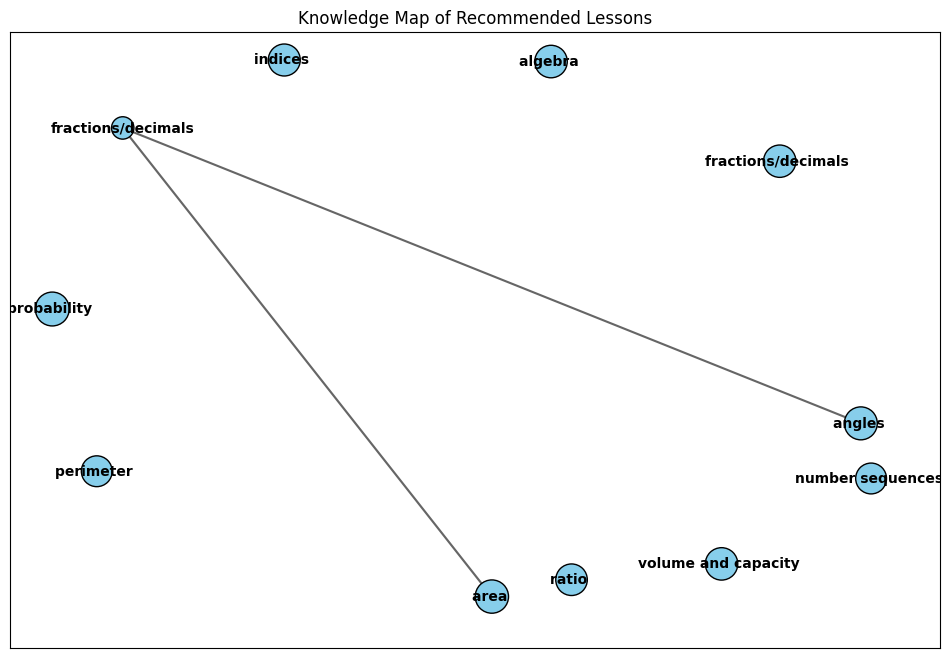

In [9]:
# Extract relevant features (e.g., recommended lessons and performance in topics)
lesson_features = ['number sequences marks', 'perimeter marks', 'ratio marks', 
                   'fractions/decimals marks', 'indices marks', 'algebra marks', 
                   'angles marks', 'volume and capacity marks', 'area marks', 'probability marks']

# Compute mean performance for each lesson
lesson_means = data.groupby("recommended_lesson")[lesson_features].mean()

# Create a graph
G = nx.Graph()

# Add nodes (lessons)
for lesson in lesson_means.index:
    G.add_node(lesson, size=lesson_means.loc[lesson].mean())

# Add edges based on correlations between topics
corr_matrix = lesson_means.T.corr()

for lesson1 in lesson_means.index:
    for lesson2 in lesson_means.index:
        if lesson1 != lesson2 and abs(corr_matrix.loc[lesson1, lesson2]) > 0.5:  # Strong correlation threshold
            G.add_edge(lesson1, lesson2, weight=corr_matrix.loc[lesson1, lesson2])

# Draw the knowledge map
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

# Node sizes based on average marks
node_sizes = [G.nodes[node]["size"] * 100 for node in G.nodes]

# Edge width based on correlation strength
edges = G.edges(data=True)
edge_widths = [abs(edge[2]["weight"]) * 3 for edge in edges]

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", edgecolors="black")

# Draw edges
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

plt.title("Knowledge Map of Recommended Lessons")
plt.show()

In [10]:
# Selecting feature variables (excluding the class variable and student_id)
X = data.drop(columns=["recommended_lesson", "student_id"])
y = data["recommended_lesson"]

In [11]:
# Encode the class variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

In [12]:
# Encode categorical features
encoders = {}
for col in categorical_cols:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col])
    encoders[col] = encoder

# Standardize numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [13]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Train and evaluate models
best_model = None
best_accuracy = 0
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model


Random Forest Accuracy: 0.8217
SVM Accuracy: 0.9867
KNN Accuracy: 0.5267


In [15]:
# Save the best model, scaler, and encoders
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)
with open("class_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print(f"Best model saved with accuracy: {best_accuracy:.4f}")

Best model saved with accuracy: 0.9867


In [16]:
import pandas as pd
import pickle
import numpy as np

# Load saved model, scaler, and encoders
with open("best_model.pkl", "rb") as f:
    best_model = pickle.load(f)
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
with open("label_encoders.pkl", "rb") as f:
    encoders = pickle.load(f)
with open("class_encoder.pkl", "rb") as f:
    class_encoder = pickle.load(f)

# Define the feature order from training
feature_order = ['stress_level', 'cognitive_performance', 'number sequences marks', 'perimeter marks', 'ratio marks', 
                 'fractions/decimals marks', 'indices marks', 'algebra marks', 'angles marks', 'volume and capacity marks', 
                 'area marks', 'probability marks']

# Function to preprocess input data
def preprocess_input(sample_input):
    sample_df = pd.DataFrame([sample_input])
    
    # Encode categorical features
    for col in encoders:
        if col in sample_df:
            sample_df[col] = encoders[col].transform(sample_df[col])
    
    # Ensure all expected columns are present
    for col in feature_order:
        if col not in sample_df:
            sample_df[col] = 0  # Assign default value if missing
    
    # Standardize numerical features
    numerical_cols = [col for col in feature_order if col not in encoders]
    sample_df[numerical_cols] = scaler.transform(sample_df[numerical_cols])
    
    return sample_df[feature_order]

# Function to make predictions
def predict_lesson(sample_input):
    processed_input = preprocess_input(sample_input)
    prediction = best_model.predict(processed_input)
    return class_encoder.inverse_transform(prediction)[0]

# Example sample input (modify according to dataset features)
sample_input = {
    "stress_level": "High",  
    "cognitive_performance": "Average",  
    "number sequences marks": 75, 
    "perimeter marks": 80,
    "ratio marks": 78,
    "fractions/decimals marks": 79,
    "indices marks": 83,
    "algebra marks": 78,
    "angles marks": 92,
    "volume and capacity marks": 79,
    "area marks": 90,
    "probability marks": 97
}

# Get prediction
predicted_lesson = predict_lesson(sample_input)
print(f"Predicted Recommended Lesson: {predicted_lesson}")

Predicted Recommended Lesson: number sequences 
